# Kaggle Superstore Sales Dataset - Further Analysis via SQL

**Author:** Haya Yasser<br>
**Querying Kaggle Superstore Sales Dataset using JupySQL**<br>
**Oct 2025**

## Import Libraries

In [54]:
from pathlib import Path
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## JupySQL Setup

We first set up our JupySQL environment, which will allow us to run SQL queries in-notebook.

In [77]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [79]:
# Loading the dataset via Kaggle API
if not Path("train.csv").is_file():
    urlretrieve(
        "https://www.kaggle.com/api/v1/datasets/download/rohitsahoo/sales-forecasting/train.csv",
        "train.csv",
    )

In [81]:
%sql duckdb://

In [83]:
# Displaying only 100 rows per query
%config SqlMagic.displaylimit = 100

## Analysis

We recall our dataset's structure using a **Select All** statement

In [19]:
%%sql SELECT * 
       FROM train.csv

Running query in 'duckdb://'

Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.94
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.62
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368
6,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,"Eldon Expressions Wood and Plastic Desk Accessories, Cherry Wood",48.86
7,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.28
8,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152
9,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by Samsill,18.504
10,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9


First, we wish to find out the *top 10 paying customers*.<br>
We do this by grouping the sales amount per customer, ordering that sales amount descendingly and only displaying the top 10 records.<br><br>
The top 10 paying customers have placed orders ranging from **12,129 to 25,043 dollars.**

In [21]:
%%sql SELECT "Customer Name", SUM(Sales) AS "Total Sales"
        FROM train.csv
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10

Running query in 'duckdb://'

Customer Name,Total Sales
Sean Miller,25043.05
Tamara Chand,19052.217999999997
Raymond Buch,15117.339
Tom Ashbrook,14595.62
Adrian Barton,14473.570999999998
Ken Lonsdale,14175.229
Sanjit Chand,14142.333999999999
Hunter Lopez,12873.297999999999
Sanjit Engle,12209.438000000002
Christopher Conant,12129.072


Now, we wish to label each customer as a **High, Mid or Low Value** customer depending on the *total amount they've spent on orders.*<br> We do this by creating a new field named **Customer_Segment** based on conditional logic.<br>
- A customer that has spent more than 10,000 dollars is a High Value customer.
- A customer that has spent betweem 5000 and 10,000 dollars is a Mid Value customer.
- A customer spending less than 5000 dollars is a Low Value customer.

In [23]:
%%sql SELECT "Customer Name",
       SUM(Sales) AS Total_Sales, 
       CASE 
           WHEN SUM(Sales) > 10000 THEN 'High Value'
           WHEN SUM(Sales) BETWEEN 5000 AND 10000 THEN 'Mid Value'
           ELSE 'Low Value'
       END AS Customer_Segment
FROM train.csv
GROUP BY "Customer Name"
ORDER BY 2 DESC

Running query in 'duckdb://'

Customer Name,Total_Sales,Customer_Segment
Sean Miller,25043.05,High Value
Tamara Chand,19052.217999999997,High Value
Raymond Buch,15117.339,High Value
Tom Ashbrook,14595.62,High Value
Adrian Barton,14473.570999999998,High Value
Ken Lonsdale,14175.229,High Value
Sanjit Chand,14142.333999999999,High Value
Hunter Lopez,12873.297999999999,High Value
Sanjit Engle,12209.438000000002,High Value
Christopher Conant,12129.072,High Value


What if we wish to find out *which category performs best per region?*<br>
To do this we group by both the **Category** and **Region** Fields.<br>
We observe that **Technology** performs the best in **all 4 regions**, followed by **Office Supplies** in the **Central and South** regions, and **Furniture** in the **East and West**.

In [105]:
%%sql SELECT Region, Category, SUM(Sales) AS "Total Sales"
        FROM train.csv
        GROUP BY 1, 2
        ORDER BY 1, 3 DESC

Running query in 'duckdb://'

Region,Category,Total Sales
Central,Technology,168739.20799999993
Central,Office Supplies,163590.24300000028
Central,Furniture,160317.46220000004
East,Technology,263116.52700000035
East,Furniture,206461.38800000006
East,Office Supplies,199940.81099999984
South,Technology,148195.20799999993
South,Office Supplies,124424.77099999994
South,Furniture,116531.4800000001
West,Technology,247404.93


Next, we would like to find out the top 10 selling products.<br>
The **Canon imageCLASS 2200 Advanced Copier** was the top selling product.

In [27]:
%%sql SELECT "Product Name", SUM(Sales) as "Product Sales"
      FROM train.csv
      GROUP BY 1
      ORDER BY 2 DESC
      LIMIT 10

Running query in 'duckdb://'

Product Name,Product Sales
Canon imageCLASS 2200 Advanced Copier,61599.824
Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind,27453.384
Cisco TelePresence System EX90 Videoconferencing Unit,22638.48
HON 5400 Series Task Chairs for Big and Tall,21870.576
GBC DocuBind TL300 Electric Binding System,19823.479000000003
GBC Ibimaster 500 Manual ProClick Binding System,19024.5
Hewlett Packard LaserJet 3310 Copier,18839.686
"HP Designjet T520 Inkjet Large Format Printer - 24"" Color",18374.895
GBC DocuBind P400 Electric Binding System,17965.068
High Speed Automatic Electric Letter Opener,17030.311999999998


We use the <code>YEAR</code> and <code>YEAR</code> functions to extract the year and month from the **Order Date** field. 

We use both those fields to view the *monthly sales trends per year*.<br>
We wish to present our data such that *each field represents a year*, and *each row is a column*.

Visualization done later will make it easier to identify peak months.

In [171]:
%%sql SELECT MONTH("Order Date") AS Month, 
  SUM(CASE WHEN YEAR("Order Date") = 2015 THEN Sales ELSE 0 END) AS "2015",
  SUM(CASE WHEN YEAR("Order Date") = 2016 THEN Sales ELSE 0 END) AS "2016",
  SUM(CASE WHEN YEAR("Order Date") = 2017 THEN Sales ELSE 0 END) AS "2017",
  SUM(CASE WHEN YEAR("Order Date") = 2018 THEN Sales ELSE 0 END) AS "2018"
FROM train.csv
GROUP BY 1
ORDER BY 1

Running query in 'duckdb://'

Month,2015,2016,2017,2018
1,14205.706999999997,18066.957599999994,18542.490999999995,43476.47399999999
2,4519.892,11951.411,22978.815000000002,19920.997399999997
3,55205.79700000003,32339.31839999999,51165.05900000002,58863.412799999984
4,27906.854999999992,34154.468499999995,38679.76699999998,35541.91010000001
5,23644.303,29959.530499999997,56656.90799999999,43825.98219999999
6,34322.93560000002,23599.374,39724.48599999998,48190.7277
7,33781.543,28608.25899999999,38320.78299999997,44825.10400000001
8,27117.536499999995,36818.34219999999,30542.2003,62837.84799999998
9,81623.52679999998,63133.606000000036,69193.39089999998,86152.88800000004
10,31453.39299999999,31011.737500000014,59583.03300000001,77448.13119999997


## Visualization

We will use **Seaborn** accompanied with **MatPlotLib** to visualize the results of our SQL queries.<br> We store the results of our queries in a variable of type <code>ResultSet</code>, which we then convert to a <code>DataFrame</code> so we can visualize the data.

We first wish to find out *which US region obtained the most sales*.<br>
We do this via a simple <code>GROUP BY</code>-based query.

We can see that the **West** region was the *most successful*, while the **South** was the *least*.

In [221]:
plt.style.use('seaborn-v0_8')

Running query in 'duckdb://'

<Axes: title={'center': 'Total Sales, by region'}, xlabel='Region', ylabel='Total_Sales'>

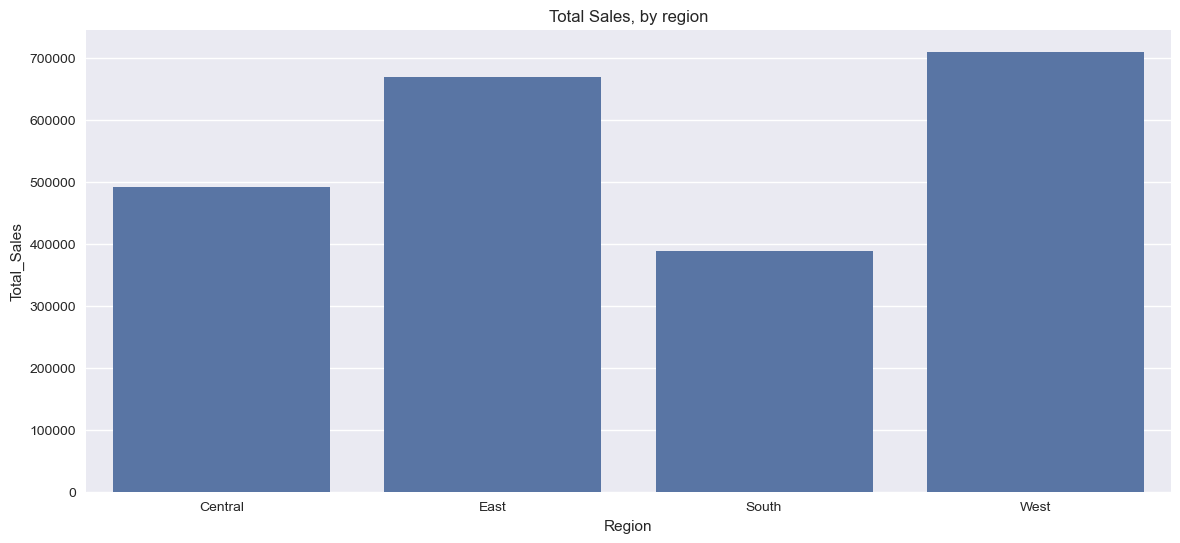

In [223]:
result = %sql SELECT Region, SUM(Sales) AS Total_Sales FROM train.csv GROUP BY 1 ORDER BY 1
type(result)
df = result.DataFrame()


plt.figure(figsize=(14, 6))
plt.title("Total Sales, by region")
sns.barplot(x=df["Region"], y=df["Total_Sales"])

Recall the query we used earlier to *identify the top 10 paying customers*.<br>

We use a bar chart to reinforce the results of that query.<br> We can see that **Sean Miller** invested the most into the store by a considerable margin compared to the second-most paying customer - **more than 5000 dollars**.

Running query in 'duckdb://'

<Axes: title={'center': 'Total Sales, per customer'}, xlabel='Customer Name', ylabel='Total_Sales'>

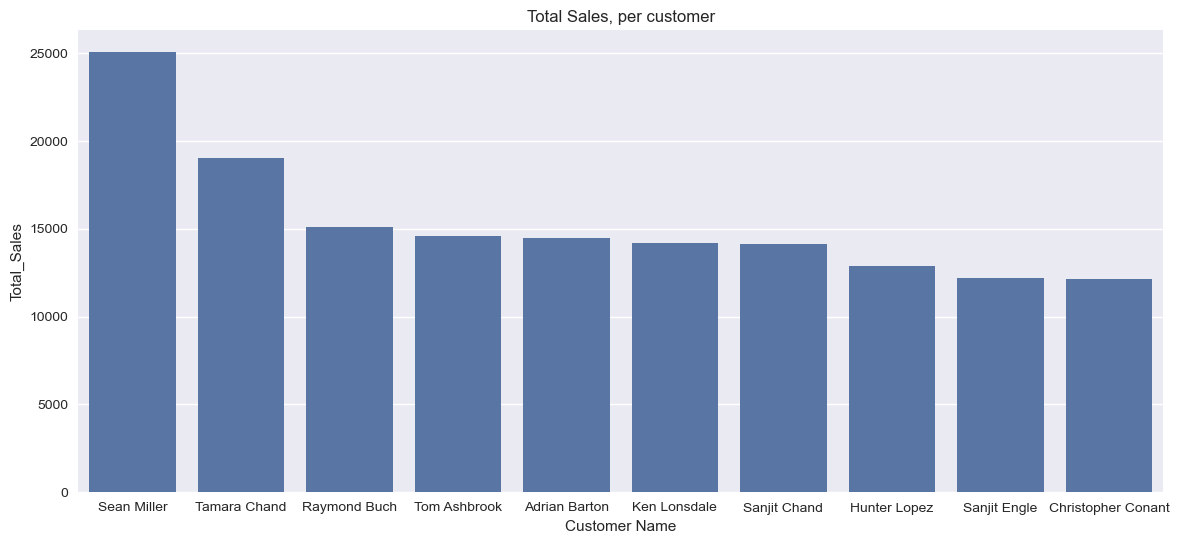

In [226]:
result = %sql SELECT "Customer Name", SUM(Sales) AS Total_Sales FROM train.csv GROUP BY 1 ORDER BY 2 DESC LIMIT 10
df = result.DataFrame()

plt.figure(figsize=(14, 6))
plt.title("Total Sales, per customer")
sns.barplot(x=df["Customer Name"], y=df["Total_Sales"])

As aforementioned, we visualize the m*onthly sales trend per year* query to identify peak months more easily.<br>
We use a **line chart** for that purpose.

It is much easier now to identify that across all four years, sales peaked during **March, September and November**.

Running query in 'duckdb://'

<Axes: title={'center': 'Monthly Sales Trend per Year'}, xlabel='Month'>

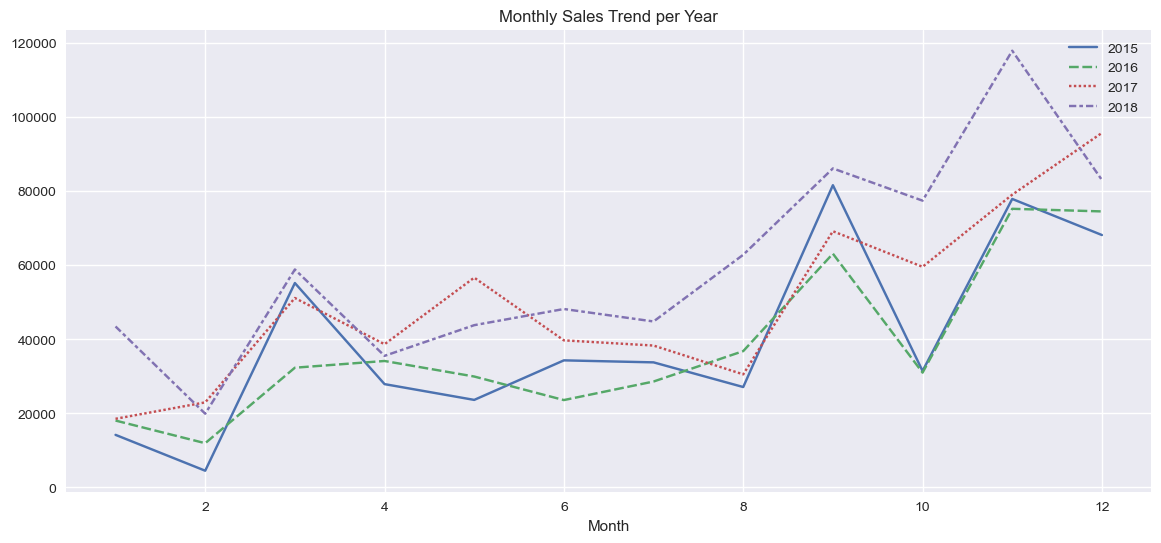

In [229]:
query = """
SELECT MONTH("Order Date") AS Month, 
  SUM(CASE WHEN YEAR("Order Date") = 2015 THEN Sales ELSE 0 END) AS "2015",
  SUM(CASE WHEN YEAR("Order Date") = 2016 THEN Sales ELSE 0 END) AS "2016",
  SUM(CASE WHEN YEAR("Order Date") = 2017 THEN Sales ELSE 0 END) AS "2017",
  SUM(CASE WHEN YEAR("Order Date") = 2018 THEN Sales ELSE 0 END) AS "2018"
FROM train.csv
GROUP BY 1
ORDER BY 1
"""

result = %sql {{query}}
df = result.DataFrame().set_index("Month")

plt.figure(figsize=(14, 6))
plt.title("Monthly Sales Trend per Year")
sns.lineplot(data=df)

## Final Insights

Based on this EDA of the Superstore Dataset across both <code>sql_basics.ipynb</code> and <code>superstore_analysis.ipynb</code>, we come to the following conclusions:
- The dataset consists of **9800** orders made to a Superstore across **4 years** by **793 unique customers**.
- In that duration, the store enjoyed **over 2.2 million dollars** in sales.
- The average order sold for **231 dollars**.
- The city responsible for the most sales was **New York**, with **over 250k dollars** in sales.
- The product category resulting in the largest portion **(almost 40%)** of sales was **Technology**, which performed the best in all 4 regions of the US: **Central, South, East, West**. 
- Superstore was the *most successful* in the **West** region, and the *least successful* in the **South**.
- The top paying customer was **Sean Miller** who contributed to **25k dollars** in sales.
- The **Canon imageCLASS 2200 Advanced Copier** was the top selling product, with **61k dollars** in sales.
- Across all 4 years, sales usually peak in the following 3 months: **March, September and November.**